In [ ]:
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
import mplhep
RANDOM_STATE = 42
plt.style.use(mplhep.style.ATLAS)

In [2]:
X, y = make_moons(n_samples=5000, noise=0.05, random_state=42)

In [3]:
X.shape, y.shape

((5000, 2), (5000,))

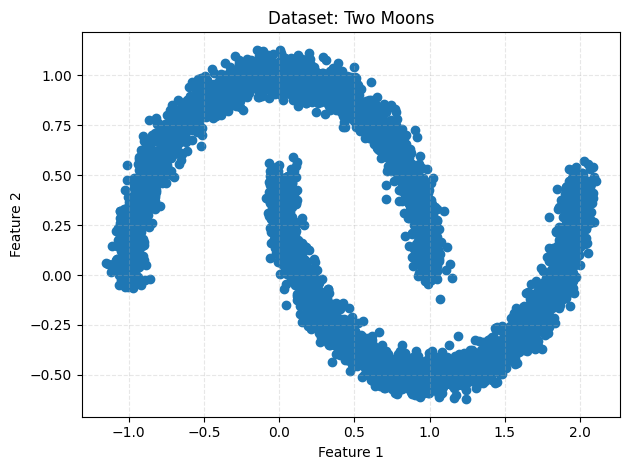

In [8]:
fig, ax = plt.subplots()
ax.grid(alpha=.3, linestyle='--')
ax.scatter(X[:, 0], X[:, 1])
ax.set(
    title='Dataset: Two Moons',
    xlabel='Feature 1',
    ylabel='Feature 2'
)
fig.tight_layout()